In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install transformers
!pip install datasets==1.18.3
!pip install transformers==4.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 311 kB 5.1 MB/s 
     |████████████████████████████████| 182 kB 47.3 MB/s 
     |████████████████████████████████| 115 kB 61.6 MB/s 
     |████████████████████████████████| 212 kB 63.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 5.1 MB/s 
     |████████████████████████████████| 880 kB 56.3 MB/s 
     |████████████████████████████████| 7.6 MB 45.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e6dcbb62ae279da5c0f182bf66e194075c5ae84ffd341bac765362db26b13235
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
# Imports
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
from scipy.special import softmax
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Label to idx
label2idx = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

idx2label = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

def merge_sentiments(sentiment):
  if sentiment < 2:
    return "Negative"
  elif sentiment == 2:
    return "Neutral"

  return "Positive"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Times Education/Speech Recognition/datasets/Copy of train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
# Merge sentiments into 3 classes
df['Sentiment'] = df['Sentiment'].map(merge_sentiments)

# Create a column for numeric label
df['label'] = df['Sentiment'].map(label2idx)

df.head()

,PhraseId,SentenceId,Phrase,Sentiment,label
0,1,1,A series of escapades demonstrating the adage ...,Negative,0
1,2,1,A series of escapades demonstrating the adage ...,Neutral,1
2,3,1,A series,Neutral,1
3,4,1,A,Neutral,1
4,5,1,series,Neutral,1


In [ ]:
# Set model checkpoint
model_ckpt = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
# Create the dataset dict
train_ds = Dataset.from_pandas(df.sample(frac=0.8).reset_index(drop=True))
test_ds = Dataset.from_pandas(df.sample(frac=0.2).reset_index(drop=True))
dataset_dict = DatasetDict({"train":train_ds,"test":test_ds})

In [ ]:
# Tokenizer function
def tokenize(batch):
    return tokenizer(batch['Phrase'], padding=True, max_length=256, truncation=True)

dataset_dict_encoded = dataset_dict.map(tokenize, batched=True, batch_size=100)

  0%|          | 0/1249 [00:00<?, ?ba/s]

  0%|          | 0/313 [00:00<?, ?ba/s]

In [ ]:
# Set device and initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = df['label'].unique()
print(labels)

num_classes = len(labels)
print(num_classes)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, 
                                                           num_labels=num_classes, 
                                                           output_attentions=False, 
                                                           output_hidden_states=False, 
                                                           ignore_mismatched_sizes=True).to(device)

[0 1 2]
3


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Metrics calculation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    return {
      'accuracy': accuracy,
      'f1': f1
    }

In [ ]:
# Set batch size and model save steps
batch_size = 16
steps_per_epoch = int((len(dataset_dict['train']) / batch_size) * 6.8)
steps_per_epoch

53060

In [ ]:
# Set model location and training arguments
model_name = f"/content/drive/MyDrive/Times Education/Speech Recognition/transformer_model"
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=7,
                                  learning_rate=5e-6,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size * 2,
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  eval_steps=steps_per_epoch, # Change it
                                  disable_tqdm=False,
                                  save_steps=steps_per_epoch,
                                  logging_steps=steps_per_epoch,
                                  log_level="error",
                                  # save_total_limit = 6,
                                  metric_for_best_model = 'f1', # By default, eval_loss is used
                                  load_best_model_at_end=True)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_dict_encoded["train"],
                  eval_dataset=dataset_dict_encoded["test"],
                  tokenizer=tokenizer,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)])

In [ ]:
# Train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy,F1
425,0.132300,0.037135,0.990000,0.989962


TrainOutput(global_step=441, training_loss=0.1294783084841272, metrics={'train_runtime': 197.0936, 'train_samples_per_second': 35.516, 'train_steps_per_second': 2.238, 'total_flos': 910142201098368.0, 'train_loss': 0.1294783084841272, 'epoch': 7.0})

In [ ]:
# Predict output and calculate metrics
y_pred_output = trainer.predict(dataset_dict_encoded["test"])
y_pred_output.metrics

{'test_loss': 0.0371348075568676,
 'test_accuracy': 0.99,
 'test_f1': 0.9899620855636696,
 'test_runtime': 2.237,
 'test_samples_per_second': 134.108,
 'test_steps_per_second': 4.47}

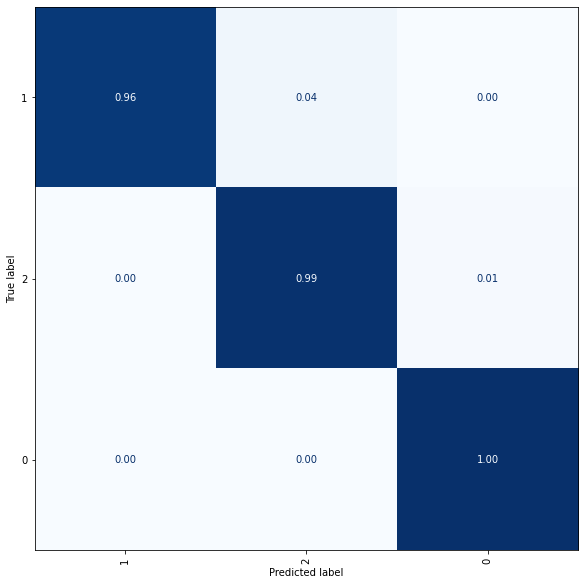

In [ ]:
# Show confusion matrix
y_valid = np.array(dataset_dict_encoded["test"]["label"])
y_valid_pred = np.argmax(y_pred_output.predictions, axis=1)
cm = confusion_matrix(y_valid_pred, y_valid, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')

In [ ]:
# Print classification report
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       0.99      1.00      0.99       233
           2       1.00      0.95      0.98        42

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300

